In [1]:
import pandas as pd
import numpy as np
from nlp import preprocessing as pp

In [2]:
cefr_df = pd.read_csv('data/cefr_df.csv')

In [3]:
cefr_df

,Unnamed: 0,documents,cefr_level,avg_word_len,num_of_words,A1,A2,B1,B2,C1,...,VBG,FW,POS,$,.,NNPS,RBR,:,RBS,WP$
0,0,Sandra picked up the bag of peanuts. It was a ...,A1,4.23,121,76,11,23,6,0,...,0,0,0,0,0,0,0,0,0,0
1,1,"Mommy. I don't feel good.\nWhat's wrong, Josep...",A1,4.57,35,27,5,1,2,0,...,0,0,0,0,0,0,0,0,0,0
2,2,Herman didn't like his first name. He had neve...,A1,4.13,106,85,6,7,2,0,...,0,0,0,0,0,0,0,0,0,0
3,3,Dora wanted to buy a card for her mother. Her ...,A1,3.96,105,98,5,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,Sally had a cold. Her nose was red. She pulled...,A1,4.05,112,75,12,18,3,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3026,3026,"The classic Sorites, or ‘heap argument’, seeks...",C2,5.03,437,252,53,44,31,0,...,5,0,0,1,0,1,0,0,0,0
3027,3027,In 1932 Marcuse published one of the first rev...,C2,5.41,861,472,84,97,70,6,...,11,0,0,0,0,0,2,0,0,0
3028,3028,Federal officials said Thursday more needs to ...,C2,5.44,392,193,44,69,48,0,...,10,0,0,0,0,0,0,5,0,0
3029,3029,The number of Americans filing new application...,C2,5.32,819,422,93,96,71,2,...,17,0,0,0,0,3,1,0,0,0


In [4]:
cefr_drop = ['documents','cefr_level']
cefr_documents = cefr_df.drop(cefr_drop, axis=1)
cefr_target = cefr_df['cefr_level']
from sklearn.model_selection import train_test_split

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, LSTM, Reshape, Embedding, TextVectorization,Bidirectional,concatenate,Flatten,GRU

In [6]:
label_mapping = {'A1':0,'A2': 1, 'B1': 2, 'B2': 3,'C1':4,'C2':5}
y_train_encoded = np.array([label_mapping[label] for label in cefr_target])

# Convert integer labels to one-hot encoded categorical labels
y_train_categorical = to_categorical(y_train_encoded)

In [7]:
X_train, X_test, y_train_categorical, y_test = train_test_split(cefr_documents, y_train_categorical, test_size=0.2, random_state=42,stratify=y_train_categorical)

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, SpatialDropout1D, Dense, Attention, Add,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Input layer
inputs = Input(shape=(X_train.shape[1], 1))

# Bidirectional LSTM layer with return sequences
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(inputs)
lstm_out = Dropout(0.2)(lstm_out)

# Bidirectional LSTM layer with return sequences
lstm_out = Bidirectional(LSTM(128, return_sequences=True))(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)

# Bidirectional LSTM layer without return sequences
lstm_out = Bidirectional(LSTM(256))(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)

# Attention mechanism
attention = Attention()([lstm_out, lstm_out])

# Residual connection
residual = Add()([lstm_out, attention])

# Dense layers
dense_out = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(residual)
dense_out = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense_out)


outputs = Dense(6, activation='softmax')(dense_out)


model = Model(inputs=inputs, outputs=outputs)

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


callbacks = [EarlyStopping(monitor='loss', patience=5, min_delta=0.0001, verbose=1)]


with tf.device('/device:GPU:0'):
    history = model.fit(X_train, y_train_categorical, epochs=100, batch_size=16,
                        validation_split=0.2, callbacks=callbacks)


Epoch 1/100
122/122 [==============================] - 28s 70ms/step - loss: 2.2687 - accuracy: 0.3378 - val_loss: 1.9589 - val_accuracy: 0.3381
Epoch 2/100
122/122 [==============================] - 5s 40ms/step - loss: 1.8316 - accuracy: 0.3945 - val_loss: 1.7317 - val_accuracy: 0.3485
Epoch 3/100
122/122 [==============================] - 5s 41ms/step - loss: 1.6594 - accuracy: 0.4167 - val_loss: 1.5719 - val_accuracy: 0.4495
Epoch 4/100
122/122 [==============================] - 5s 38ms/step - loss: 1.4241 - accuracy: 0.4740 - val_loss: 1.3994 - val_accuracy: 0.5093
Epoch 5/100
122/122 [==============================] - 5s 38ms/step - loss: 1.3077 - accuracy: 0.5173 - val_loss: 1.4546 - val_accuracy: 0.4680
Epoch 6/100
122/122 [==============================] - 5s 38ms/step - loss: 1.1665 - accuracy: 0.5482 - val_loss: 1.2933 - val_accuracy: 0.4639
Epoch 7/100
122/122 [==============================] - 5s 41ms/step - loss: 0.9762 - accuracy: 0.6209 - val_loss: 1.6640 - val_accuracy

In [11]:
_, train_acc = model.evaluate(X_train, y_train_categorical, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

19/19 [==============================] - 1s 28ms/step - loss: 0.2384 - accuracy: 0.9209
Train: 0.934, Test: 0.921


In [12]:
accr = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

19/19 [==============================] - 1s 30ms/step - loss: 0.2384 - accuracy: 0.9209
Test set
  Loss: 0.238
  Accuracy: 0.921


In [13]:
from matplotlib import pyplot as plt

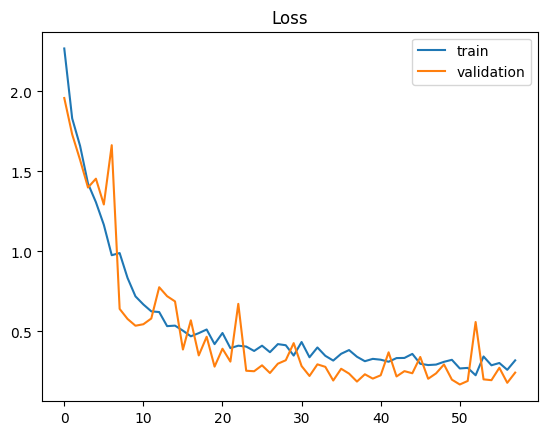

In [14]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

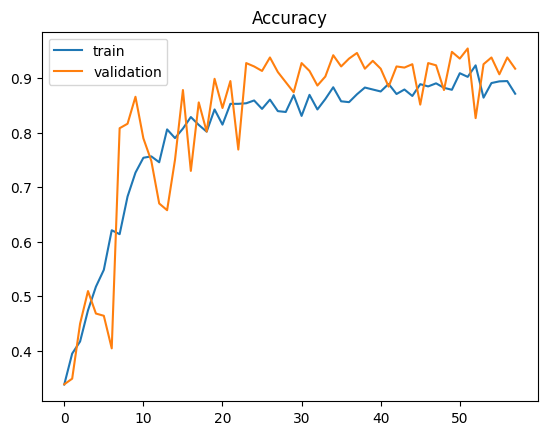

In [15]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

report = classification_report(y_true_classes, y_pred_classes)
print(report)


19/19 [==============================] - 4s 28ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        57
           1       0.96      0.96      0.96       122
           2       0.93      0.80      0.86        94
           3       0.86      0.96      0.91       129
           4       0.96      0.85      0.90       110
           5       0.88      1.00      0.94        95

    accuracy                           0.92       607
   macro avg       0.93      0.92      0.92       607
weighted avg       0.92      0.92      0.92       607



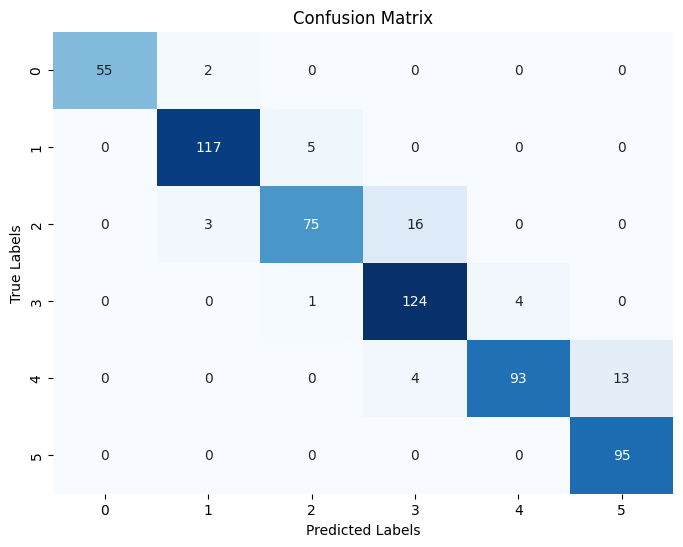

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [18]:
#misclassifications
misclassifications = [(true_label, pred_label) for true_label, pred_label in zip(y_true_classes, y_pred_classes) if true_label != pred_label]
print(f"Total number of misclassifations : {len(misclassifications)} / {len(y_test)} ")
#for true_label, pred_label in misclassifications:
    #print(f"True Label: {true_label}, Predicted Label: {pred_label}")


Total number of misclassifations : 48 / 607 
